# Attention Mechanism

## Loading Libraries

In [17]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches

# Dataset's Iteration Performance
from tqdm import tqdm

# Time
import time

# OS
import re
import sys
import json
import string
import unicodedata
from glob import glob
from io import BytesIO
from imageio import imread
from zipfile import ZipFile
import requests, zipfile, io
from urllib.request import urlopen



# SciPy
from scipy.signal import convolve

# PyTorch
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import *
from torchvision.ops import nms
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


# IDLMAM Libraries
from idlmam import moveTo, run_epoch, set_seed, View
from idlmam import train_simple_network, set_seed, Flatten, weight_reset, train_network
from idlmam import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep, LambdaLayer


# Scikit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#  IPython Display
from IPython.display import Latex
from IPython.display import display_pdf
from IPython.display import set_matplotlib_formats

### Visualization Set-Up

In [4]:
%matplotlib inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

### Setting Seeds

In [5]:
torch.backends.cudnn.deterministic=True

set_seed(42)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Loading Data

### Attention Mechanism Learn Relative Input Importance

In [7]:
# Train Data
mnist_train = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)

# Test Data
mnist_test = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden

100%|██████████| 9912422/9912422 [00:00<00:00, 131742974.07it/s]
Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden

100%|██████████| 28881/28881 [00:00<00:00, 26605687.20it/s]
Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden

100%|██████████| 1648877/1648877 [00:00<00:00, 111259514.10it/s]
Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden

100%|██████████| 4542/4542 [00:00<00:00, 6377813.45it/s]
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
class LargestDigit(Dataset):
    def __init__(self, dataset, toSample=3):
        self.dataset = dataset
        self.toSample = toSample

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        selected = np.random.randint(0,len(self.dataset), size=self.toSample)
        x_new = torch.stack([self.dataset[i][0] for i in selected])
        y_new = max([self.dataset[i][1] for i in selected])
        return x_new, y_new

### Baseline Model Training

In [9]:
# Batch Size
B = 128

# Epochs
epochs = 10

# Largerst Train & Test Sets
largest_train = LargestDigit(mnist_train)
largest_test = LargestDigit(mnist_test)

# Data Loaders
train_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
test_loader = DataLoader(largest_test, batch_size=B)

In [11]:
# 
set_seed(34)

True Label is =  4


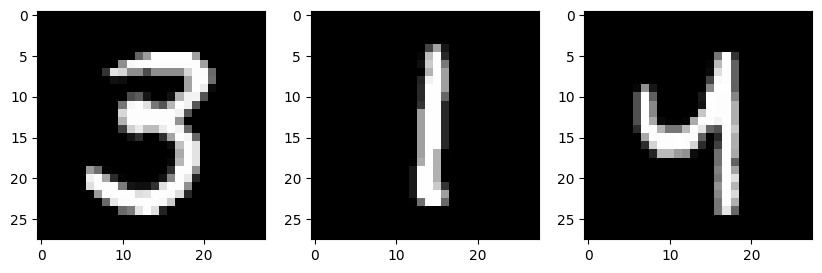

In [12]:
x, y = largest_train[0]

f, axarr = plt.subplots(1,3, figsize=(10,10))

for i in range(3):
    axarr[i].imshow(x[i,0,:].numpy(), cmap='gray', vmin=0, vmax=1)

print("True Label is = ", y)

Fully Connected Baseline Model:

In [13]:
# Neurons
neurons = 256

# Classes
classes = 10

simpleNet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784*3,neurons), 
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, classes )
)    

Model Training:

In [14]:
simple_results = train_network(simpleNet, 
nn.CrossEntropyLoss(), 
train_loader, 
val_loader=test_loader, 
epochs=epochs, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

Training: 100%|█████████▉| 468/469 [00:59<00:00,  7.97it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:59<00:00,  7.89it/s]
                                                           
Epoch: 100%|██████████| 10/10 [11:34<00:00, 69.42s/it]


### Attention Mechanism Mechanics

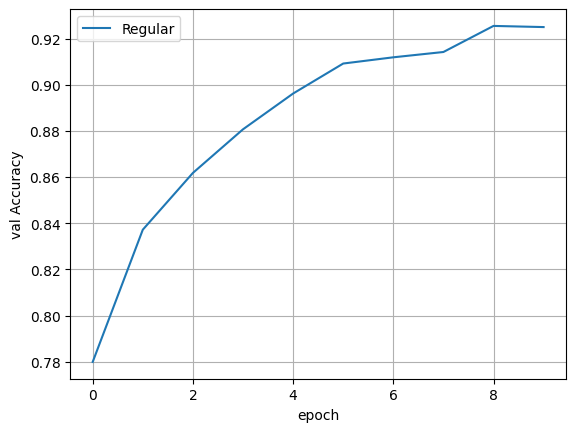

In [15]:
sns.lineplot(x='epoch', 
y='val Accuracy',
 data=simple_results, 
 label='Regular')

plt.grid(True)
plt.show()

### Implementing a Simple Attention Mechanism

In [16]:
class Flatten2(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), input.size(1), -1)

Defining The Combiner Module:

In [18]:
class Combiner(nn.Module):
    def __init__(self, featureExtraction, weightSelection):
        super(Combiner, self).__init__()
        self.featureExtraction = featureExtraction
        self.weightSelection = weightSelection
    
    def forward(self, input):
        features = self.featureExtraction(input) 
        weights = self.weightSelection(features) 
        if len(weights.shape) == 2: 
            weights.unsqueese(2) 
        
        r = features*weights 
        
        return torch.sum(r, dim=1) 

Defining The Backbone Network:

In [19]:
# Bag Items
T = 3

# Feature's Number
D = 784

In [20]:
backboneNetwork = nn.Sequential(
    Flatten2(),
    nn.Linear(D,neurons), 
    nn.LeakyReLU(),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(), 
)

Defining an Attention SubNetwork:

In [21]:
attentionMechanism = nn.Sequential(
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons, 1 ), 
    nn.Softmax(dim=1),
)

Training a Simple Attention Model & Results:

In [22]:
simpleAttentionNet = nn.Sequential(
        Combiner(backboneNetwork, attentionMechanism), 
        nn.BatchNorm1d(neurons),
        nn.Linear(neurons,neurons),
        nn.LeakyReLU(),
        nn.BatchNorm1d(neurons),
        nn.Linear(neurons, classes )
    )

In [23]:
simple_attn_results = train_network(simpleAttentionNet, 
nn.CrossEntropyLoss(), 
train_loader, 
val_loader=test_loader, 
epochs=epochs, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

Training: 100%|█████████▉| 468/469 [01:00<00:00,  7.88it/s]
                                                           
Training: 100%|██████████| 469/469 [01:00<00:00,  7.98it/s]
                                                           
Epoch: 100%|██████████| 10/10 [11:43<00:00, 70.37s/it]


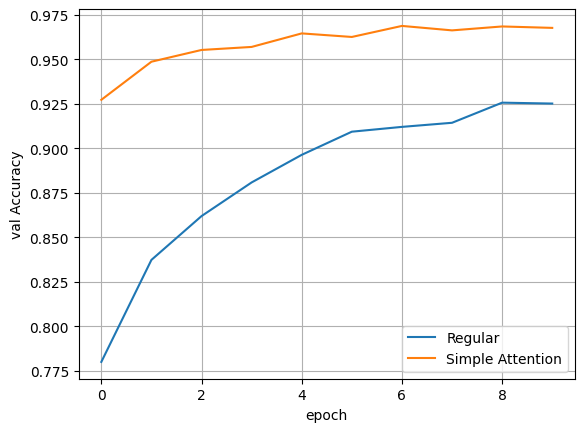

In [24]:
sns.lineplot(x='epoch', 
y='val Accuracy', 
data=simple_results, 
label='Regular')

sns.lineplot(x='epoch', 
y='val Accuracy', 
data=simple_attn_results, 
label='Simple Attention')

plt.grid(True)
plt.show()

In [ ]:
# set_seed(1)

In [25]:
x, y = largest_train[0] 

x = x.to(device) 

with torch.no_grad():
    weights = attentionMechanism(backboneNetwork(x.unsqueeze(0))) 
    weights = weights.cpu().numpy().ravel() 

True Label is =  6


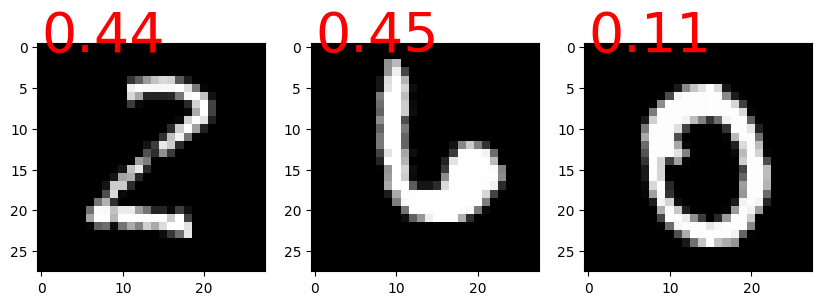

In [26]:
f, axarr = plt.subplots(1,3, figsize=(10,10))

for i in range(3):
    axarr[i].imshow(x[i,0,:].cpu().numpy(), cmap='gray', vmin=0, vmax=1) 
    axarr[i].text(0.0, 0.5, str(round(weights[i],2)), dict(size=40, color='red')) 
    
print("True Label is = ", y)

## Adding Some Context

### Dot Score

In [27]:
class DotScore(nn.Module):
    def __init__(self, H):
        super(DotScore, self).__init__()
        self.H = H
    
    def forward(self, states, context):
        T = states.size(1)
        scores = torch.bmm(states,context.unsqueeze(2)) / np.sqrt(self.H) 
        return scores

### General Score

In [28]:
class GeneralScore(nn.Module):
    def __init__(self, H):
        super(GeneralScore, self).__init__()
        self.w = nn.Bilinear(H, H, 1) 
    
    def forward(self, states, context):
        T = states.size(1)
        context = torch.stack([context for _ in range(T)], dim=1) 
        scores = self.w(states, context) 
        return scores        

### Additive Attention

In [29]:
class AdditiveAttentionScore(nn.Module):
    def __init__(self, H):
        super(AdditiveAttentionScore, self).__init__()
        self.v = nn.Linear(H, 1) 
        self.w = nn.Linear(2*H, H)
    
    def forward(self, states, context):
        T = states.size(1)
        context = torch.stack([context for _ in range(T)], dim=1) 
        state_context_combined = torch.cat((states, context), dim=2) 
        scores = self.v(torch.tanh(self.w(state_context_combined))) 
        return scores

### Computing Attention Weights

Helper Module as follows:

In [30]:
class ApplyAttention(nn.Module):
    def __init__(self):
        super(ApplyAttention, self).__init__()
        
    def forward(self, states, attention_scores, mask=None):
        if mask is not None:
            attention_scores[~mask] = -1000.0
        weights = F.softmax(attention_scores, dim=1) 
    
        final_context = (states*weights).sum(dim=1) 
        return final_context, weights

In [31]:
def getMaskByFill(x, time_dimension=1, fill=0):
    to_sum_over = list(range(1,len(x.shape))) 
    
    if time_dimension in to_sum_over:
        to_sum_over.remove(time_dimension)
        
    with torch.no_grad(): 
        mask = torch.sum((x != fill), dim=to_sum_over) > 0
    return mask

In [32]:
with torch.no_grad():
    x = torch.rand((5,3,1,7,7))
    x[0,-1,:] = 0 
    x[3,:] = 0 
    x[4,0,0,0] = 0 
    
    
    mask = getMaskByFill(x)

print(mask)

tensor([[ True,  True, False],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False, False],
        [ True,  True,  True]])


## Putting All Together: A Complete Attention mechanism with Context

In [34]:
class SmarterAttentionNet(nn.Module):

    def __init__(self, input_size, hidden_size, out_size, score_net=None):
        super(SmarterAttentionNet, self).__init__()
        self.backbone = nn.Sequential(
            Flatten2(),
            nn.Linear(input_size,hidden_size), 
            nn.LeakyReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
        )
        
        self.score_net = AdditiveAttentionScore(hidden_size) if (score_net is None) else score_net

        self.apply_attn = ApplyAttention()
        
        self.prediction_net = nn.Sequential(  
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, out_size ) 
        )
           
    def forward(self, input):
        mask = getMaskByFill(input)
        h = self.backbone(input) 
        h_context = (mask.unsqueeze(-1)*h).sum(dim=1)
        h_context = h_context/(mask.sum(dim=1).unsqueeze(-1)+1e-10)
        scores = self.score_net(h, h_context) 
        final_context, _ = self.apply_attn(h, scores, mask=mask)
        return self.prediction_net(final_context)

In [35]:
# DotScore Attention Function
attn_dot = SmarterAttentionNet(D, neurons, classes, score_net=DotScore(neurons))

# General Score Attention Function
attn_gen = SmarterAttentionNet(D, neurons, classes, score_net=GeneralScore(neurons))

# Additive Attention Score Function
attn_add = SmarterAttentionNet(D, neurons, classes, score_net=AdditiveAttentionScore(neurons))

DotScore Attention Model Training

In [36]:
attn_results_dot = train_network(attn_dot, 
nn.CrossEntropyLoss(), 
train_loader, 
val_loader=test_loader,
epochs=epochs, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

Training: 100%|██████████| 469/469 [01:00<00:00,  8.14it/s]
                                                           
Training: 100%|█████████▉| 468/469 [01:00<00:00,  7.72it/s]
                                                           
Epoch: 100%|██████████| 10/10 [11:44<00:00, 70.44s/it]


General Score Attention Model Training

In [37]:
attn_results_gen = train_network(attn_gen, 
nn.CrossEntropyLoss(), 
train_loader, 
val_loader=test_loader, 
epochs=epochs, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

Training: 100%|██████████| 469/469 [01:00<00:00,  7.57it/s]
                                                           
Training: 100%|██████████| 469/469 [01:01<00:00,  7.80it/s]
                                                           
Epoch: 100%|██████████| 10/10 [11:47<00:00, 70.75s/it]


Additive Attention Score Model Training

In [38]:
attn_results_add = train_network(attn_add, 
nn.CrossEntropyLoss(), 
train_loader, 
val_loader=test_loader,
epochs=epochs, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

Training: 100%|█████████▉| 468/469 [01:02<00:00,  7.04it/s]
                                                           
Training: 100%|█████████▉| 468/469 [01:00<00:00,  7.27it/s]
                                                           
Epoch: 100%|██████████| 10/10 [11:48<00:00, 70.81s/it]


Plotting Model's Outcome

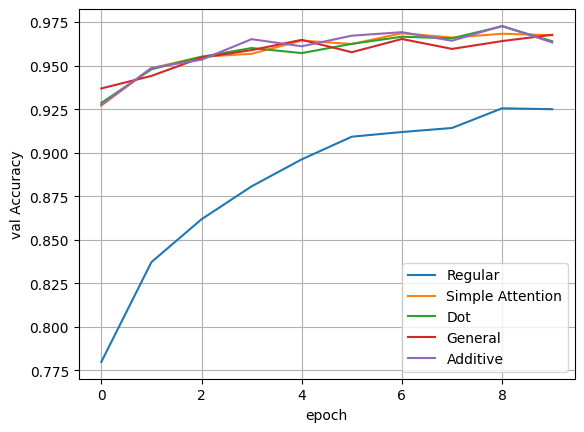

In [39]:
# Simple Results
sns.lineplot(x='epoch', 
y='val Accuracy', 
data=simple_results, 
label='Regular')

# Simple Attention
sns.lineplot(x='epoch', 
y='val Accuracy', 
data=simple_attn_results, 
label='Simple Attention')

# DotScore Attention
sns.lineplot(x='epoch', 
y='val Accuracy', 
data=attn_results_dot, 
label='Dot')

# General Score Attention
sns.lineplot(x='epoch', 
y='val Accuracy', 
data=attn_results_gen, 
label='General')

# Additive Attention Score
sns.lineplot(x='epoch', 
y='val Accuracy', 
data=attn_results_add, 
label='Additive')


plt.grid(True)
plt.show()

In [40]:
class LargestDigitVariable(Dataset):

    def __init__(self, dataset, maxToSample=6):
        self.dataset = dataset
        self.maxToSample = maxToSample

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        how_many = np.random.randint(1,self.maxToSample, size=1)[0]
        selected = np.random.randint(0,len(self.dataset), size=how_many)

        x_new = torch.stack([self.dataset[i][0] for i in selected] + 
                            [torch.zeros((1,28,28)) for i in range(self.maxToSample-how_many)])
        
        y_new = max([self.dataset[i][1] for i in selected])
        return x_new, y_new

In [41]:
largestV_train = LargestDigitVariable(mnist_train)
largestV_test = LargestDigitVariable(mnist_test)

trainV_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
testV_loader = DataLoader(largest_test, batch_size=B)

In [42]:
attn_dot = attn_dot.eval()

preds = []
truths = []

with torch.no_grad():
    for inputs, labels in testV_loader:
        pred = attn_dot(inputs.to(device))
        pred = torch.argmax(pred, dim=1).cpu().numpy()
        
        preds.extend(pred.ravel())
        truths.extend(labels.numpy().ravel())

print("Variable Length Accuracy: ", accuracy_score(preds, truths))

Variable Length Accuracy:  0.9644


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b2b3c5ee-4473-4def-a9f7-7e1bada8d3c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>